In [130]:
import os
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay, roc_curve
from sklearn import metrics
from tqdm import tqdm

def give_inputs(cell_line):
    
    if cell_line == "HEK293T":  
        samples = [["outTable_599710609", "outTable_905657585"],
                   ["outTable_572868058", "outTable_364841872"],
                   ["outTable_110067244", "outTable_597789462"]]

    elif cell_line == "HEK":
        samples = [["outTable_724242056", "outTable_816573740"],
                   ["outTable_580067564", "outTable_718392497"],
                   ["outTable_181728208", "outTable_854894021"]]

    else:
        samples = [["outTable_192318299", "outTable_436061877"],
                   ["outTable_535670354", "outTable_396704193"],
                   ["outTable_773331943", "outTable_302610513"]]
   
    filespath = "/lustrehome/pietrolucamazzacuva/filezilla-recas/tissues/independent_datasets/{}".format(cell_line)
    return samples, filespath

def editpredict_data_preparation(tables, filespath, editpredictpath):
    
    with tqdm(total=6) as pbar:
        for i in range(3):
            sites = pd.read_table(os.path.join(filespath, f"{tables[i][0]}_{tables[i][1]}_bona_fide_sites.tsv"), 
                                 usecols = ["Region", "Position", "Class", "RMSK-Reg"])
            wt = pd.read_table(f"{filespath}/{tables[i][0]}_intervals.tsv", sep="\t", usecols=["Region", "Position", "Strand"])
            adars_inactive = pd.read_table(f"{filespath}/{tables[i][1]}_intervals.tsv", sep="\t", usecols=["Region", "Position", "Strand"])
            wt.loc[:, "index_wt"] = wt.index.tolist()
            adars_inactive.loc[:, "index_adars_inactive"] = adars_inactive.index.tolist()
            merged = wt.merge(adars_inactive, how ="inner", on=["Region", "Position", "Strand"])
            merged.drop("Strand", axis=1, inplace=True)

            merged = merged.merge(sites, how="inner", on=["Region", "Position"])
            common_pos = merged[merged.loc[:, "Class"]==1]
            index_common_pos = common_pos.loc[:, "index_wt"].tolist()
            merged = merged[merged.loc[:, "Class"]==0]
            
            index_wt = merged["index_wt"].tolist()
            index_adars_inactive = merged["index_adars_inactive"].tolist()
            merged.drop(["index_wt", "index_adars_inactive"], axis=1, inplace=True)
            wt.drop(["Strand", "index_wt"], axis=1, inplace=True)
            adars_inactive.drop(["Strand", "index_adars_inactive"], axis=1, inplace=True)
            
            snps_adars_inactive = adars_inactive.iloc[index_adars_inactive, :]
            sites_ko = snps_adars_inactive.merge(sites, how="inner", on=["Region", "Position"])
            
            snps_wt = wt.iloc[index_wt, :]
            index_drop = index_common_pos + index_wt
            index_drop.sort()
            pos = wt.drop(index_drop)
            pos = pos.merge(sites, how="inner", on=["Region", "Position"])
            snps_wt = snps_wt.merge(sites, how="inner", on=["Region", "Position"])
            sites_wt = pd.concat([pos, snps_wt], axis=0)
            sites_wt.reset_index(drop=True, inplace=True)
            
            for j in range(2):
                intervals = pd.read_table(os.path.join(filespath, f"{tables[i][j]}_intervals.tsv"), usecols=["Region", "Position"])
                if j ==0:
                    intervals = intervals.merge(sites_wt, how="inner", on=["Region", "Position"])
                else:
                    intervals = intervals.merge(sites_ko, how="inner", on=["Region", "Position"])
                intervals.sort_values(by=["Region", "Position"], inplace=True)

                intervals.loc[:, "Region"] = intervals.loc[:, "Region"].apply(return_contig)

                alu = intervals[intervals.loc[:,  "RMSK-Reg"].str.find("Alu") != -1]
                not_alu = intervals[intervals.loc[:,  "RMSK-Reg"].str.find("Alu") == -1]

                alu.drop("RMSK-Reg", axis=1, inplace=True)
                not_alu.drop("RMSK-Reg", axis=1, inplace=True)

                alu.loc[:, ["Region", "Position"]].to_csv(os.path.join(editpredictpath, f"{tables[i][j]}_editpredict_check_alu.txt"), 
                                                          index=None, header=False, sep="\t")
                alu.to_csv(os.path.join(editpredictpath, f"{tables[i][j]}_editpredict_check_alu_classes.tsv"), index=None, sep="\t")
                
                not_alu.loc[:, ["Region", "Position"]].to_csv(os.path.join(editpredictpath, f"{tables[i][j]}_editpredict_check_not_alu.txt"), 
                                                              index=None, header=False, sep="\t")
                not_alu.to_csv(os.path.join(editpredictpath, f"{tables[i][j]}_editpredict_check_not_alu_classes.tsv"), index=None, sep="\t")

                pbar.update(1)

def return_contig(x):
    return x.replace("chr", "")

In [2]:
cells = "HEK293T"

tables, filespath = give_inputs(cells)

editpredictpath = os.path.join(filespath, f"{cells}_editpredict")
if not os.path.isdir(editpredictpath):
    os.mkdir(editpredictpath)
    
editpredict_data_preparation(tables, filespath, editpredictpath)

  0%|          | 0/6 [00:00<?, ?it/s]/lustrehome/pietrolucamazzacuva/anaconda3/envs/tensorflow-gpu/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
100%|██████████| 6/6 [00:00<00:00,  8.61it/s]


In [3]:
cells = "a549"

tables, filespath = give_inputs(cells)

editpredictpath = os.path.join(filespath, f"{cells}_editpredict")
if not os.path.isdir(editpredictpath):
    os.mkdir(editpredictpath)
    
editpredict_data_preparation(tables, filespath, editpredictpath)

100%|██████████| 6/6 [00:00<00:00,  9.34it/s]


In [133]:
cells = "HEK293T"

samples = ["outTable_599710609", "outTable_572868058", "outTable_110067244", 
           "outTable_905657585", "outTable_364841872", "outTable_597789462" ]

conversionpath = "/lustrehome/pietrolucamazzacuva/filezilla-recas/tissues"
filespath = "/lustrehome/pietrolucamazzacuva/filezilla-recas/tissues/independent_datasets/{}/{}_editpredict".format(cells, cells)
savepath = "/lustrehome/pietrolucamazzacuva/filezilla-recas/tissues/independent_datasets/{}/{}_RDDpred_RED-ML".format(cells, cells)
if not os.path.isdir(savepath):
    os.mkdir(savepath)

def return_contig(x):
    return "chr{}".format(x)

positives = []
negatives = []

conversion_table = pd.read_table(os.path.join(conversionpath, "HEK293T_BonaFide_LiftOver_ConversionTable.txt"))

for i in range(6):
    
        df = pd.read_csv(f"{filespath}/{samples[i]}_editpredict_check_alu_classes.tsv", sep="\t")
        df = pd.concat([df, pd.read_csv(f"{filespath}/{samples[i]}_editpredict_check_not_alu_classes.tsv", sep="\t")], axis=0)
        df.loc[:, "Region"] = df.loc[:, "Region"].apply(return_contig)
        df.loc[:, "Class"] =  df.loc[:, "Class"].astype("int32")

        df.sort_values(by=["Region", "Position"], inplace=True)
        df.columns = ["Region-Hg38", "Position-Hg38", "Class"]
        
        df.to_csv(f"{savepath}/{samples[i]}_BonaFide_Hg38.txt", sep="\t", index=None)
        df = df.merge(conversion_table, how="inner", on=["Region-Hg38", "Position-Hg38"])
        df.sort_values(by=["Region-Hg19", "Position-Hg19"], inplace=True)
        df.drop(["Region-Hg38", "Position-Hg38"], axis=1, inplace=True)
        df = df.loc[:, ["Region-Hg19", "Position-Hg19", "Class"]]
        df.to_csv(f"{savepath}/{samples[i]}_BonaFide_Hg19.txt", sep="\t", index=None)
        

In [131]:
def return_contig(x):
    return "chr{}".format(x)
                
def data_preparation(tool):
    
    savepath = "/lustrehome/pietrolucamazzacuva/filezilla-recas/tissues/independent_datasets/HEK293T/ROC-AUC"      
    if not os.path.isdir(savepath):
        os.mkdir(savepath)
    
    if tool == "REDInet":
        
        tables = [["outTable_599710609", "outTable_905657585"],
                  ["outTable_572868058", "outTable_364841872"],
                  ["outTable_110067244", "outTable_597789462"]]
        
        tables_filespath = "/lustrehome/pietrolucamazzacuva/filezilla-recas/tissues/independent_datasets/HEK293T"
    
        for i in range(3):

            sites = pd.read_table(os.path.join(tables_filespath, f"{tables[i][0]}_{tables[i][1]}_bona_fide_sites.tsv"),
                                  sep="\t", usecols=["Region", "Position", "Class"])

            cols =  ["Region", "Position", "Strand", "Editing_Probability"]
            wt = pd.read_csv(os.path.join(tables_filespath, f"{tables[i][0]}_predictions.tsv"), sep="\t", usecols=cols)
            adars_inactive = pd.read_csv(os.path.join(tables_filespath, f"{tables[i][1]}_predictions.tsv"), sep="\t", usecols=cols)

            wt.loc[:, "index_wt"] = wt.index.tolist()
            adars_inactive.loc[:, "index_adars_inactive"] = adars_inactive.index.tolist()
            merged = wt.merge(adars_inactive, how ="inner", on=["Region", "Position", "Strand"])
            merged = merged.merge(sites, how="inner", on=["Region", "Position"])
            common_pos = merged[merged.loc[:, "Class"]==1]
            index_common_pos = common_pos.loc[:, "index_wt"].tolist()
            merged = merged[merged.loc[:, "Class"]==0]


            index_adars_inactive = merged.loc[:, "index_adars_inactive"].tolist()
            index_wt = merged.loc[:, "index_wt"].tolist()
            snps_adars_inactive = adars_inactive.iloc[index_adars_inactive, :]
            snps_adars_inactive.drop(["Strand", "index_adars_inactive"], axis=1, inplace=True)
            snps_adars_inactive.loc[:, "Class"] = [0 for i in range(len(snps_adars_inactive))]
            snps_wt = wt.iloc[index_wt, :]
            snps_wt.drop(["Strand", "index_wt"], axis=1, inplace=True)
            snps_wt.loc[:, "Class"] = [0 for i in range(len(snps_wt))]

            index_drop = index_common_pos + index_wt
            index_drop.sort()
            pos = wt.drop(index_drop)
            pos = pos.merge(sites, how="inner", on=["Region", "Position"])
            pos.drop(["Strand", "index_wt", "Class"], axis=1, inplace=True)
            pos.loc[:, "Class"] = [1 for i in range(len(pos))]
            pos = pd.concat([pos, snps_wt], axis=0)

            pos.to_csv(os.path.join(savepath, f"{tables[i][0]}_REDInet_ROC-AUC_Data.txt"), index=None, sep="\t")
            snps_adars_inactive.to_csv(os.path.join(savepath, f"{tables[i][1]}_REDInet_ROC-AUC_Data.txt"), index=None, sep="\t")
        
    elif tool == "EditPredict":
        
        tables = [["outTable_599710609", "outTable_905657585"],
                  ["outTable_572868058", "outTable_364841872"],
                  ["outTable_110067244", "outTable_597789462"]]
        
        tables_filespath = "/lustrehome/pietrolucamazzacuva/filezilla-recas/tissues/independent_datasets/HEK293T/HEK293T_editpredict"

        for i in range(3):
            
            for j in range(2):
                
                tableout = pd.DataFrame()
                cols = ["Chromosome", "Position", "NO_prob"]
                for annotation in ["alu", "not_alu"]:
                    prediction = pd.read_table(os.path.join(tables_filespath, f"Predict_result_{tables[i][j]}_{annotation}.txt"), 
                                               usecols=cols)
                    prediction.loc[:, "Editing_Probability"] = 1.0 - prediction.loc[:, "NO_prob"]
                    prediction.drop("NO_prob", axis=1, inplace=True)
                    prediction.columns = ["Region", "Position", "Editing_Probability"]
                    bonafide = pd.read_csv(os.path.join(tables_filespath, f"{tables[i][j]}_editpredict_check_{annotation}_classes.tsv"), 
                                           sep="\t")
                    prediction = prediction.merge(bonafide, how="inner", on=["Region", "Position"])
                    tableout = pd.concat([tableout, prediction], axis=0)
                
                tableout.sort_values(by=["Region", "Position"], inplace=True)
                tableout.loc[:, "Region"] = tableout.loc[:, "Region"].apply(return_contig)
                
                tableout.to_csv(os.path.join(savepath, f"{tables[i][j]}_EditPredict_ROC-AUC_Data.txt"), index=None, sep="\t")
                
    elif tool == "RED-ML":
        
        tables = [["outTable_599710609", "outTable_572868058"],
                  ["outTable_110067244", "outTable_905657585"],
                  ["outTable_364841872", "outTable_597789462"]]
        
        datapath = "/lustrehome/pietrolucamazzacuva/share"
        tables_filespath = "/lustrehome/pietrolucamazzacuva/filezilla-recas/tissues/independent_datasets/HEK293T/HEK293T_RDDpred_RED-ML"
        
        for i in range(3):
            for j in range(2):
                
                k = 2*i+j+1
            
                cols = ["Region-Hg19", "Position-Hg19", "Editing_Probability"]
               
                if k != 1:
                    tableout = pd.read_table(os.path.join(datapath, f"RED-ML-RESULTS{k}/RNA_editing.sites.txt"), low_memory=False, 
                                             skiprows=[0], header=None, usecols=[0,1,7]) 
                else:
                    tableout = pd.read_table(os.path.join(datapath, f"RED-ML-RESULTS/RNA_editing.sites.txt"), low_memory=False, 
                                            skiprows=[0], header=None, usecols=[0,1,7]) 

                tableout.columns = cols
                tableout.drop(0, axis=0, inplace=True)
                tableout.dropna(axis=0, inplace=True)
                tableout.reset_index(drop=True, inplace=True)
                
                tableout.iloc[:, 1] = tableout.iloc[:, 1].astype("int32")
                tableout.iloc[:, 0] = tableout.iloc[:, 0].astype("str")
                tableout.iloc[:, 2] = tableout.iloc[:, 2].astype("float32")

                tableout.sort_values(by=["Region-Hg19", "Position-Hg19"], inplace=True)

                classes = pd.read_table(os.path.join(tablespath, f"{tables[i][j]}_BonaFide_Hg19.txt"))
                classes.iloc[:, 1] = classes.iloc[:, 1].astype("int32")
                classes.iloc[:, 0] = classes.iloc[:, 0].astype("str")
                classes.iloc[:, 2] = classes.iloc[:, 2].astype("int32")

                tableout = tableout.merge(classes, how="inner", on=["Region-Hg19", "Position-Hg19"])

                tableout.columns = ["Region", "Position", "Editing_Probability", "Class"]
                tableout.to_csv(os.path.join(savepath, f"{tables[i][j]}_RED-ML_ROC-AUC_Data.txt"), index=None, sep="\t")
    
    else:         
        
        tables = [["outTable_599710609", "outTable_572868058"],
                  ["outTable_110067244", "outTable_905657585"],
                  ["outTable_364841872", "outTable_597789462"]]
        
        datapath = "/lustrehome/pietrolucamazzacuva/RDDpred_v1.0.Dir/OutDir"
        tables_filespath = "/lustrehome/pietrolucamazzacuva/filezilla-recas/tissues/independent_datasets/HEK293T/HEK293T_RDDpred_RED-ML"
        
        df = pd.read_table(f"{datapath}/Test.RDDpred.results_report.txt")
        ag = df[df.iloc[:, 2] == "A"]
        ag = ag[ag.iloc[:, 3] == "G"]
        tc = df[df.iloc[:, 2] == "T"]
        tc = tc[tc.iloc[:, 3] == "C"]
        
        del df

        data = pd.concat([ag, tc], axis=0)
        
        del ag, tc
        
        data.reset_index(drop=True, inplace=True)
        data.sort_values(by=["Chromosome", "One_based_Position"], inplace=True)
        index = data[data.iloc[:, 4] != "True_Editing"].index.tolist()
        data.iloc[index, 8] = 1.0-data.iloc[index, 8]
        data.iloc[index, 9] = 1.0-data.iloc[index, 9]
        data.iloc[index, 10] = 1.0-data.iloc[index, 10]
        data.iloc[index, 11] = 1.0-data.iloc[index, 11]
        data.iloc[index, 12] = 1.0-data.iloc[index, 12]
        data.iloc[index, 13] = 1.0-data.iloc[index, 13]


        for i in range(3):
            for j in range(2): 
                
                k = 2*i+j+1
                
                tableout = data.loc[:, ["Chromosome","One_based_Position", f"Sample.{k}"]]
                tableout.columns = ["Region-Hg19", "Position-Hg19", "Editing_Probability"]
                
                classes = pd.read_table(os.path.join(tables_filespath, f"{tables[i][j]}_BonaFide_Hg19.txt"))
                tableout = tableout.merge(classes, how="inner", on=["Region-Hg19", "Position-Hg19"])
                
                tableout.columns = ["Region", "Position", "Editing_Probability", "Class"]
                tableout.to_csv(os.path.join(savepath, f"{tables[i][j]}_RDDpred_ROC-AUC_Data.txt"), index=None, sep="\t")
            
                
for _ in ["REDInet", "EditPredict", "RED-ML", "RDDpred"]:
    data_preparation(_)

/lustrehome/pietrolucamazzacuva/anaconda3/envs/tensorflow-gpu/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/lustrehome/pietrolucamazzacuva/anaconda3/envs/tensorflow-gpu/lib/python3.7/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


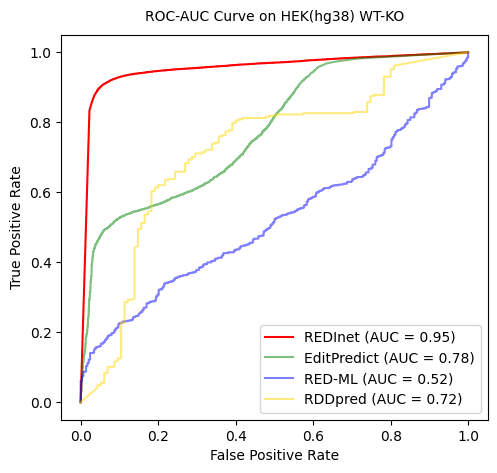

In [132]:
edi = pd.DataFrame()
redi = pd.DataFrame()
red = pd.DataFrame()
rdd = pd.DataFrame()
path = "/lustrehome/pietrolucamazzacuva/filezilla-recas/tissues/independent_datasets/HEK293T/ROC-AUC"
for name in os.listdir(path):
    df = pd.read_table(os.path.join(path, name))
    if name.find("REDInet") != -1:
        redi = pd.concat([redi, df], axis=0)
    elif name.find("RED-ML") != -1:
        red = pd.concat([red, df], axis=0)
    elif name.find("RDDpred") != -1:
        rdd = pd.concat([rdd, df], axis=0)
    else:
        edi = pd.concat([edi, df], axis=0)
        
redi_true = redi.iloc[:, 3].tolist()
redi_pred = redi.iloc[:, 2].tolist()
edi_true = edi.iloc[:, 3].tolist()
edi_pred = edi.iloc[:, 2].tolist()
red_true = red.iloc[:, 3].tolist()
red_pred = red.iloc[:, 2].tolist()
rdd_true = rdd.iloc[:, 3].tolist()
rdd_pred = rdd.iloc[:, 2].tolist()

fig, ax = plt.subplots(figsize=(5.5, 5))
fpr_redi, tpr_redi, thresholds_redi = metrics.roc_curve(redi_true, redi_pred)
AUC_redi = metrics.auc(fpr_redi, tpr_redi,)
ROC = metrics.RocCurveDisplay(fpr=fpr_redi, tpr=tpr_redi, roc_auc=AUC_redi).plot(ax=ax, color="red", name="REDInet")
fpr_edi, tpr_edi, thresholds_edi = metrics.roc_curve(edi_true, edi_pred)
AUC_edi = metrics.auc(fpr_edi, tpr_edi)
ROC_edi = metrics.RocCurveDisplay(fpr=fpr_edi, tpr=tpr_edi, roc_auc=AUC_edi).plot(ax=ax, color="green", name="EditPredict", alpha=0.5)    
fpr_red, tpr_red, thresholds_red = metrics.roc_curve(red_true, red_pred)
AUC_red = metrics.auc(fpr_red, tpr_red)
ROC_red = metrics.RocCurveDisplay(fpr=fpr_red, tpr=tpr_red, roc_auc=AUC_red).plot(ax=ax, color="blue", name="RED-ML", alpha=0.5)
fpr_rdd, tpr_rdd, thresholds_rdd = metrics.roc_curve(rdd_true, rdd_pred)
AUC_rdd = metrics.auc(fpr_rdd, tpr_rdd)
ROC_rdd = metrics.RocCurveDisplay(fpr=fpr_rdd, tpr=tpr_rdd, roc_auc=AUC_rdd).plot(ax=ax, color="gold", name="RDDpred", alpha=0.5)
ax.set_title(f"ROC-AUC Curve on HEK(hg38) WT-KO", fontsize=10, pad=10)
plt.savefig(f"{path}/ROC-AUC_on_HEK293T_WT_KO.tiff", dpi=300, facecolor='white', transparent=False) 
plt.show()



